# "Cross-validation" des modèles

In [1]:
learning_rate = 0.05
num_epochs = 3000
N = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6):
    
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y


In [4]:
import torch
criterion = torch.nn.BCELoss()

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                verbose=False):
    torch.set_default_tensor_type('torch.DoubleTensor')
    from torch.nn import functional as F

    class LogisticRegressionModel(torch.nn.Module):
        def __init__(self):
            super(LogisticRegressionModel, self).__init__()
            self.linear = torch.nn.Linear(1, 1, bias=False)    
            self.logit0 = torch.nn.Linear(1, 1) 

        def forward(self, x):
            p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
            out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
            return out

    logistic_model = LogisticRegressionModel()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)

    theta, p, y = get_data()
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    for epoch in range(int(num_epochs)):

        optimizer.zero_grad()
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print Loss
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch}. Loss: {loss.item():.5f}.")

    logistic_model.eval()
    return logistic_model, loss.item()

kezako?

In [5]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0. Loss: 0.69695.
Iteration: 93. Loss: 0.41055.
Iteration: 186. Loss: 0.39686.
Iteration: 279. Loss: 0.39229.
Iteration: 372. Loss: 0.39010.
Iteration: 465. Loss: 0.38912.
Iteration: 558. Loss: 0.38867.
Iteration: 651. Loss: 0.38846.
Iteration: 744. Loss: 0.38835.
Iteration: 837. Loss: 0.38830.
Iteration: 930. Loss: 0.38828.
Iteration: 1023. Loss: 0.38827.
Iteration: 1116. Loss: 0.38826.
Iteration: 1209. Loss: 0.38826.
Iteration: 1302. Loss: 0.38826.
Iteration: 1395. Loss: 0.38826.
Iteration: 1488. Loss: 0.38826.
Iteration: 1581. Loss: 0.38826.
Iteration: 1674. Loss: 0.38826.
Iteration: 1767. Loss: 0.38826.
Iteration: 1860. Loss: 0.38826.
Iteration: 1953. Loss: 0.38826.
Iteration: 2046. Loss: 0.38826.
Iteration: 2139. Loss: 0.38826.
Iteration: 2232. Loss: 0.38826.
Iteration: 2325. Loss: 0.38826.
Iteration: 2418. Loss: 0.38826.
Iteration: 2511. Loss: 0.38826.
Iteration: 2604. Loss: 0.38826.
Iteration: 2697. Loss: 0.38826.
Iteration: 2790. Loss: 0.38826.
Iteration: 2883. Loss:

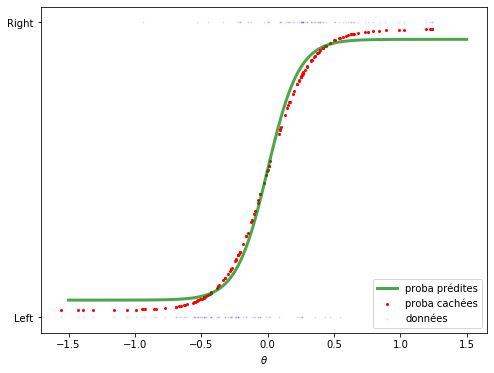

In [6]:
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


## validation

loss= tensor(0.3595, grad_fn=<BinaryCrossEntropyBackward>)


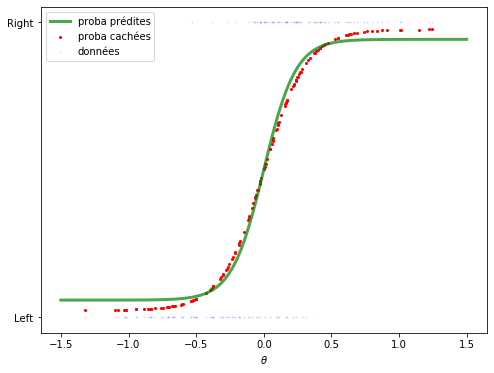

In [7]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [8]:
Ns = np.logspace(1, 4, 15, base=10)
N_test = 1000
losses, KLs = [], []
for N_ in Ns:
    theta, p, y = get_data(N=int(N_))
    logistic_model, loss = fit_data(theta, y, verbose=False)
    theta, p, y = get_data(N=N_test) # nouvelles données 
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item()
    KL = criterion(outputs, torch.Tensor(p[:, None])).item()
    print(f"N: {int(N_)}, Loss: {loss:.5f}, KL: {KL:.5f}.")
    KLs.append(KL)
    losses.append(loss)

N: 10, Loss: 0.37397, KL: 0.41015.
N: 16, Loss: 0.39307, KL: 0.38167.
N: 26, Loss: 0.37942, KL: 0.37557.
N: 43, Loss: 0.35821, KL: 0.39812.
N: 71, Loss: 0.35027, KL: 0.37663.
N: 117, Loss: 0.40043, KL: 0.37892.
N: 193, Loss: 0.41632, KL: 0.40944.
N: 316, Loss: 0.44236, KL: 0.38474.
N: 517, Loss: 0.39983, KL: 0.41349.
N: 848, Loss: 0.37235, KL: 0.39598.
N: 1389, Loss: 0.41355, KL: 0.38611.
N: 2275, Loss: 0.36557, KL: 0.39157.
N: 3727, Loss: 0.40186, KL: 0.40023.
N: 6105, Loss: 0.38151, KL: 0.38731.
N: 10000, Loss: 0.36669, KL: 0.39747.


Text(0, 0.5, ' Loss ')

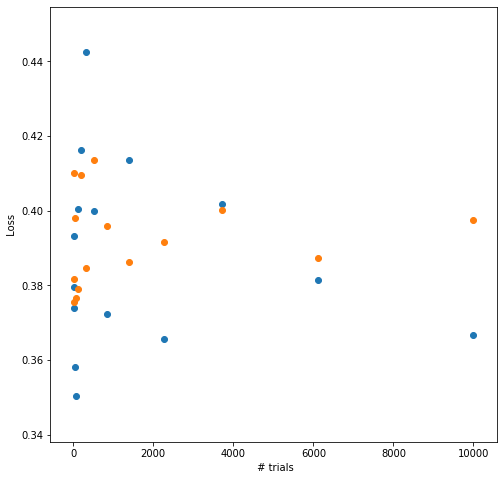

In [9]:
plt.figure(figsize = (8,8)) 
plt.scatter(Ns, losses)
plt.scatter(Ns, KLs)
plt.xlabel(' # trials')
plt.ylabel(' Loss ')

## influence du nombre du learning rate


In [10]:

learning_rates = learning_rate * np.logspace(-1, 1, 15, base=10)
losses, KLs = [], []
for learning_rate_ in learning_rates:
    theta, p, y = get_data()
    logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)
    
    theta, p, y = get_data(N=N_test) # nouvelles données 
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    outputs = logistic_model(Theta)

    loss = criterion(outputs, labels).item()
    KL = criterion(outputs, torch.Tensor(p[:, None])).item()
    print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, KL: {KL:.5f}.")
    KLs.append(KL)
    losses.append(loss)

learning_rate: 0.00500, Loss: 0.40822, KL: 0.39106.
learning_rate: 0.00695, Loss: 0.39850, KL: 0.38750.
learning_rate: 0.00965, Loss: 0.39771, KL: 0.40424.
learning_rate: 0.01341, Loss: 0.43496, KL: 0.38704.
learning_rate: 0.01864, Loss: 0.38288, KL: 0.38780.
learning_rate: 0.02590, Loss: 0.40230, KL: 0.39292.
learning_rate: 0.03598, Loss: 0.35928, KL: 0.38296.
learning_rate: 0.05000, Loss: 0.39638, KL: 0.39163.
learning_rate: 0.06947, Loss: 0.37516, KL: 0.38568.
learning_rate: 0.09653, Loss: 0.41765, KL: 0.38763.
learning_rate: 0.13413, Loss: 0.40131, KL: 0.38221.
learning_rate: 0.18638, Loss: 0.36641, KL: 0.39302.
learning_rate: 0.25897, Loss: 0.33741, KL: 0.38700.
learning_rate: 0.35984, Loss: 0.37508, KL: 0.39238.
learning_rate: 0.50000, Loss: 0.40148, KL: 0.38886.


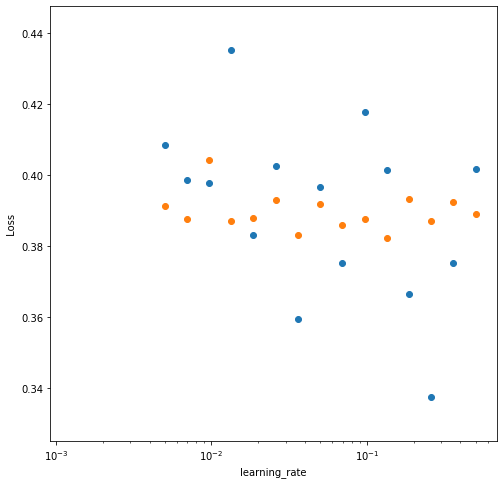

In [11]:
fig, ax = plt.subplots(figsize = (8,8)) 
ax.scatter(learning_rates, losses)
ax.scatter(learning_rates, KLs)

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du nombre d'epochs

In [12]:
num_epochss = num_epochs * np.logspace(-1, 1, 15, base=10)
losses, KLs = [], []
for num_epochs_ in num_epochss:
    theta, p, y = get_data()
    logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
    theta, p, y = get_data(N=1000) # nouvelles données 
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    outputs = logistic_model(Theta)

    loss = criterion(outputs, labels).item()
    KL = criterion(outputs, torch.Tensor(p[:, None])).item()
    print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, KL: {KL:.5f}.")
    KLs.append(KL)
    losses.append(loss)

num_epochs: 300, Loss: 0.40184, KL: 0.39566.
num_epochs: 416, Loss: 0.36949, KL: 0.38373.
num_epochs: 579, Loss: 0.38390, KL: 0.39039.
num_epochs: 804, Loss: 0.40171, KL: 0.39405.
num_epochs: 1118, Loss: 0.41598, KL: 0.38818.
num_epochs: 1553, Loss: 0.40625, KL: 0.39378.
num_epochs: 2159, Loss: 0.36003, KL: 0.39008.
num_epochs: 3000, Loss: 0.34255, KL: 0.38502.
num_epochs: 4168, Loss: 0.38635, KL: 0.38264.
num_epochs: 5792, Loss: 0.42134, KL: 0.40609.
num_epochs: 8048, Loss: 0.41068, KL: 0.39037.
num_epochs: 11182, Loss: 0.39806, KL: 0.38531.
num_epochs: 15538, Loss: 0.38629, KL: 0.37522.
num_epochs: 21590, Loss: 0.43365, KL: 0.39192.
num_epochs: 30000, Loss: 0.38995, KL: 0.39426.


Text(0, 0.5, ' Loss ')

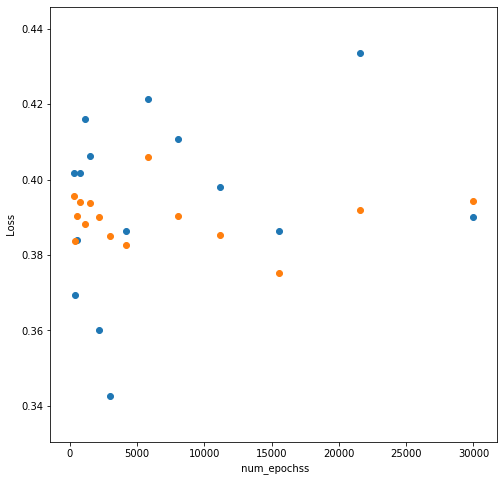

In [13]:
plt.figure(figsize = (8,8)) 
plt.scatter(num_epochss, losses)
plt.scatter(num_epochss, KLs)
plt.xlabel(' num_epochss')
plt.ylabel(' Loss ')